### Matrix Calculus behind Multi-class Classification

We are working with a classification model where:

- **Input Vector**:  
  $\mathbf{x} \in \mathbb{R}^m$, an input vector with $m$ features.

- **Weight Matrix**:  
  $\mathbf{W} \in \mathbb{R}^{n \times m}$, the weight matrix that maps the input vector $\mathbf{x}$ to the logits $\mathbf{z}$, where $n$ is the number of classes.

- **Logits**:  
  $\mathbf{z} \in \mathbb{R}^n$, the vector of logits (raw model outputs), where:
  $$
  \mathbf{z} = \mathbf{W} \mathbf{x}.
  $$

- **Softmax Activation**:  
  $\mathbf{p} \in \mathbb{R}^n$, the output of the softmax function applied to the logits $\mathbf{z}$:
  $$
  p_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}, \quad \forall i = 1, \dots, n.
  $$

- **True Label Vector**:  
  $\mathbf{y} \in \{0, 1\}^n$, the true label vector in a one-hot encoded format. If the true class is $i$, then $y_i = 1$, and $y_i = 0$ for all other classes.

- **Cross-Entropy Loss**:  
  The loss function is the cross-entropy loss:
  $$
  L = -\mathbf{y}^T \log(\mathbf{p}),
  $$
  where $\log(\mathbf{p})$ is the element-wise natural logarithm of the predicted probability vector $\mathbf{p}$.

---

## Objective

Our objective is to compute the gradient of the loss $L$ with respect to the weight matrix $\mathbf{W}$, i.e., $\frac{\partial L}{\partial \mathbf{W}}$.

---

## Gradients and Jacobians

### Gradient of the Loss with Respect to $\mathbf{p}$

We start by computing the gradient of the loss $L$ with respect to the predicted probability vector $\mathbf{p}$:

$$
L = -\mathbf{y}^T \log(\mathbf{p}).
$$

The gradient of $L$ with respect to $\mathbf{p}$ is:

$$
\frac{\partial L}{\partial \mathbf{p}} = -\frac{\mathbf{y}}{\mathbf{p}}.
$$

This follows from the derivative of the element-wise logarithm, which is $\frac{1}{p_i}$, and the derivative of the one-hot encoded vector $\mathbf{y}$, which is just $\mathbf{y}$.

---

### Jacobian of Softmax with Respect to $\mathbf{z}$

Next, we compute the Jacobian of the softmax function with respect to the logits $\mathbf{z}$. The softmax function maps the logits $\mathbf{z}$ to the predicted probabilities $\mathbf{p}$, and the Jacobian is:

$$
\frac{\partial p_i}{\partial z_j} = p_i (\delta_{ij} - p_j),
$$
where $\delta_{ij}$ is the Kronecker delta, which is 1 when $i = j$ and 0 otherwise.

In matrix form, the Jacobian of the softmax function with respect to the logits $\mathbf{z}$ is:

$$
\frac{\partial \mathbf{p}}{\partial \mathbf{z}} = \text{diag}(\mathbf{p}) - \mathbf{p} \mathbf{p}^T,
$$
where $\text{diag}(\mathbf{p})$ is the diagonal matrix with elements $p_1, p_2, \dots, p_n$ on the diagonal, and $\mathbf{p} \mathbf{p}^T$ is the outer product of $\mathbf{p}$ with itself.

---

### Gradient of the Loss with Respect to $\mathbf{z}$

Using the chain rule, we now compute the gradient of the loss $L$ with respect to the logits $\mathbf{z}$:

$$
\frac{\partial L}{\partial \mathbf{z}} = \frac{\partial L}{\partial \mathbf{p}} \cdot \frac{\partial \mathbf{p}}{\partial \mathbf{z}}.
$$

Substitute the expressions for $\frac{\partial L}{\partial \mathbf{p}}$ and $\frac{\partial \mathbf{p}}{\partial \mathbf{z}}$:

$$
\frac{\partial L}{\partial \mathbf{z}} = - (\text{diag}(\mathbf{p}) - \mathbf{p} \mathbf{p}^T) \cdot \frac{\mathbf{y}}{\mathbf{p}} 
$$

Simplifying, we obtain:

$$
\frac{\partial L}{\partial \mathbf{z}} = \mathbf{y} - \mathbf{p}
$$

---

### Gradient of the Loss with Respect to $\mathbf{W}$

Finally, using the chain rule, we compute the gradient of the loss $L$ with respect to the weight matrix $\mathbf{W}$. Since $\mathbf{z} = \mathbf{W} \mathbf{x}$, the gradient of $\mathbf{z}$ with respect to $\mathbf{W}$ is:

$$
\frac{\partial \mathbf{z}}{\partial \mathbf{W}} = \mathbf{x}^T
$$

Thus, the gradient of the loss $L$ with respect to the weight matrix $\mathbf{W}$ is:

$$
\frac{\partial L}{\partial \mathbf{W}} = \frac{\partial L}{\partial \mathbf{z}} \cdot \frac{\partial \mathbf{z}}{\partial \mathbf{W}} = (\mathbf{p} - \mathbf{y}) \cdot \mathbf{x}^T
$$


The final result for the gradient of the loss $L$ with respect to the weight matrix $\mathbf{W}$ is:

$$
\frac{\partial L}{\partial \mathbf{W}} = (\mathbf{p} - \mathbf{y}) \mathbf{x}^T
$$

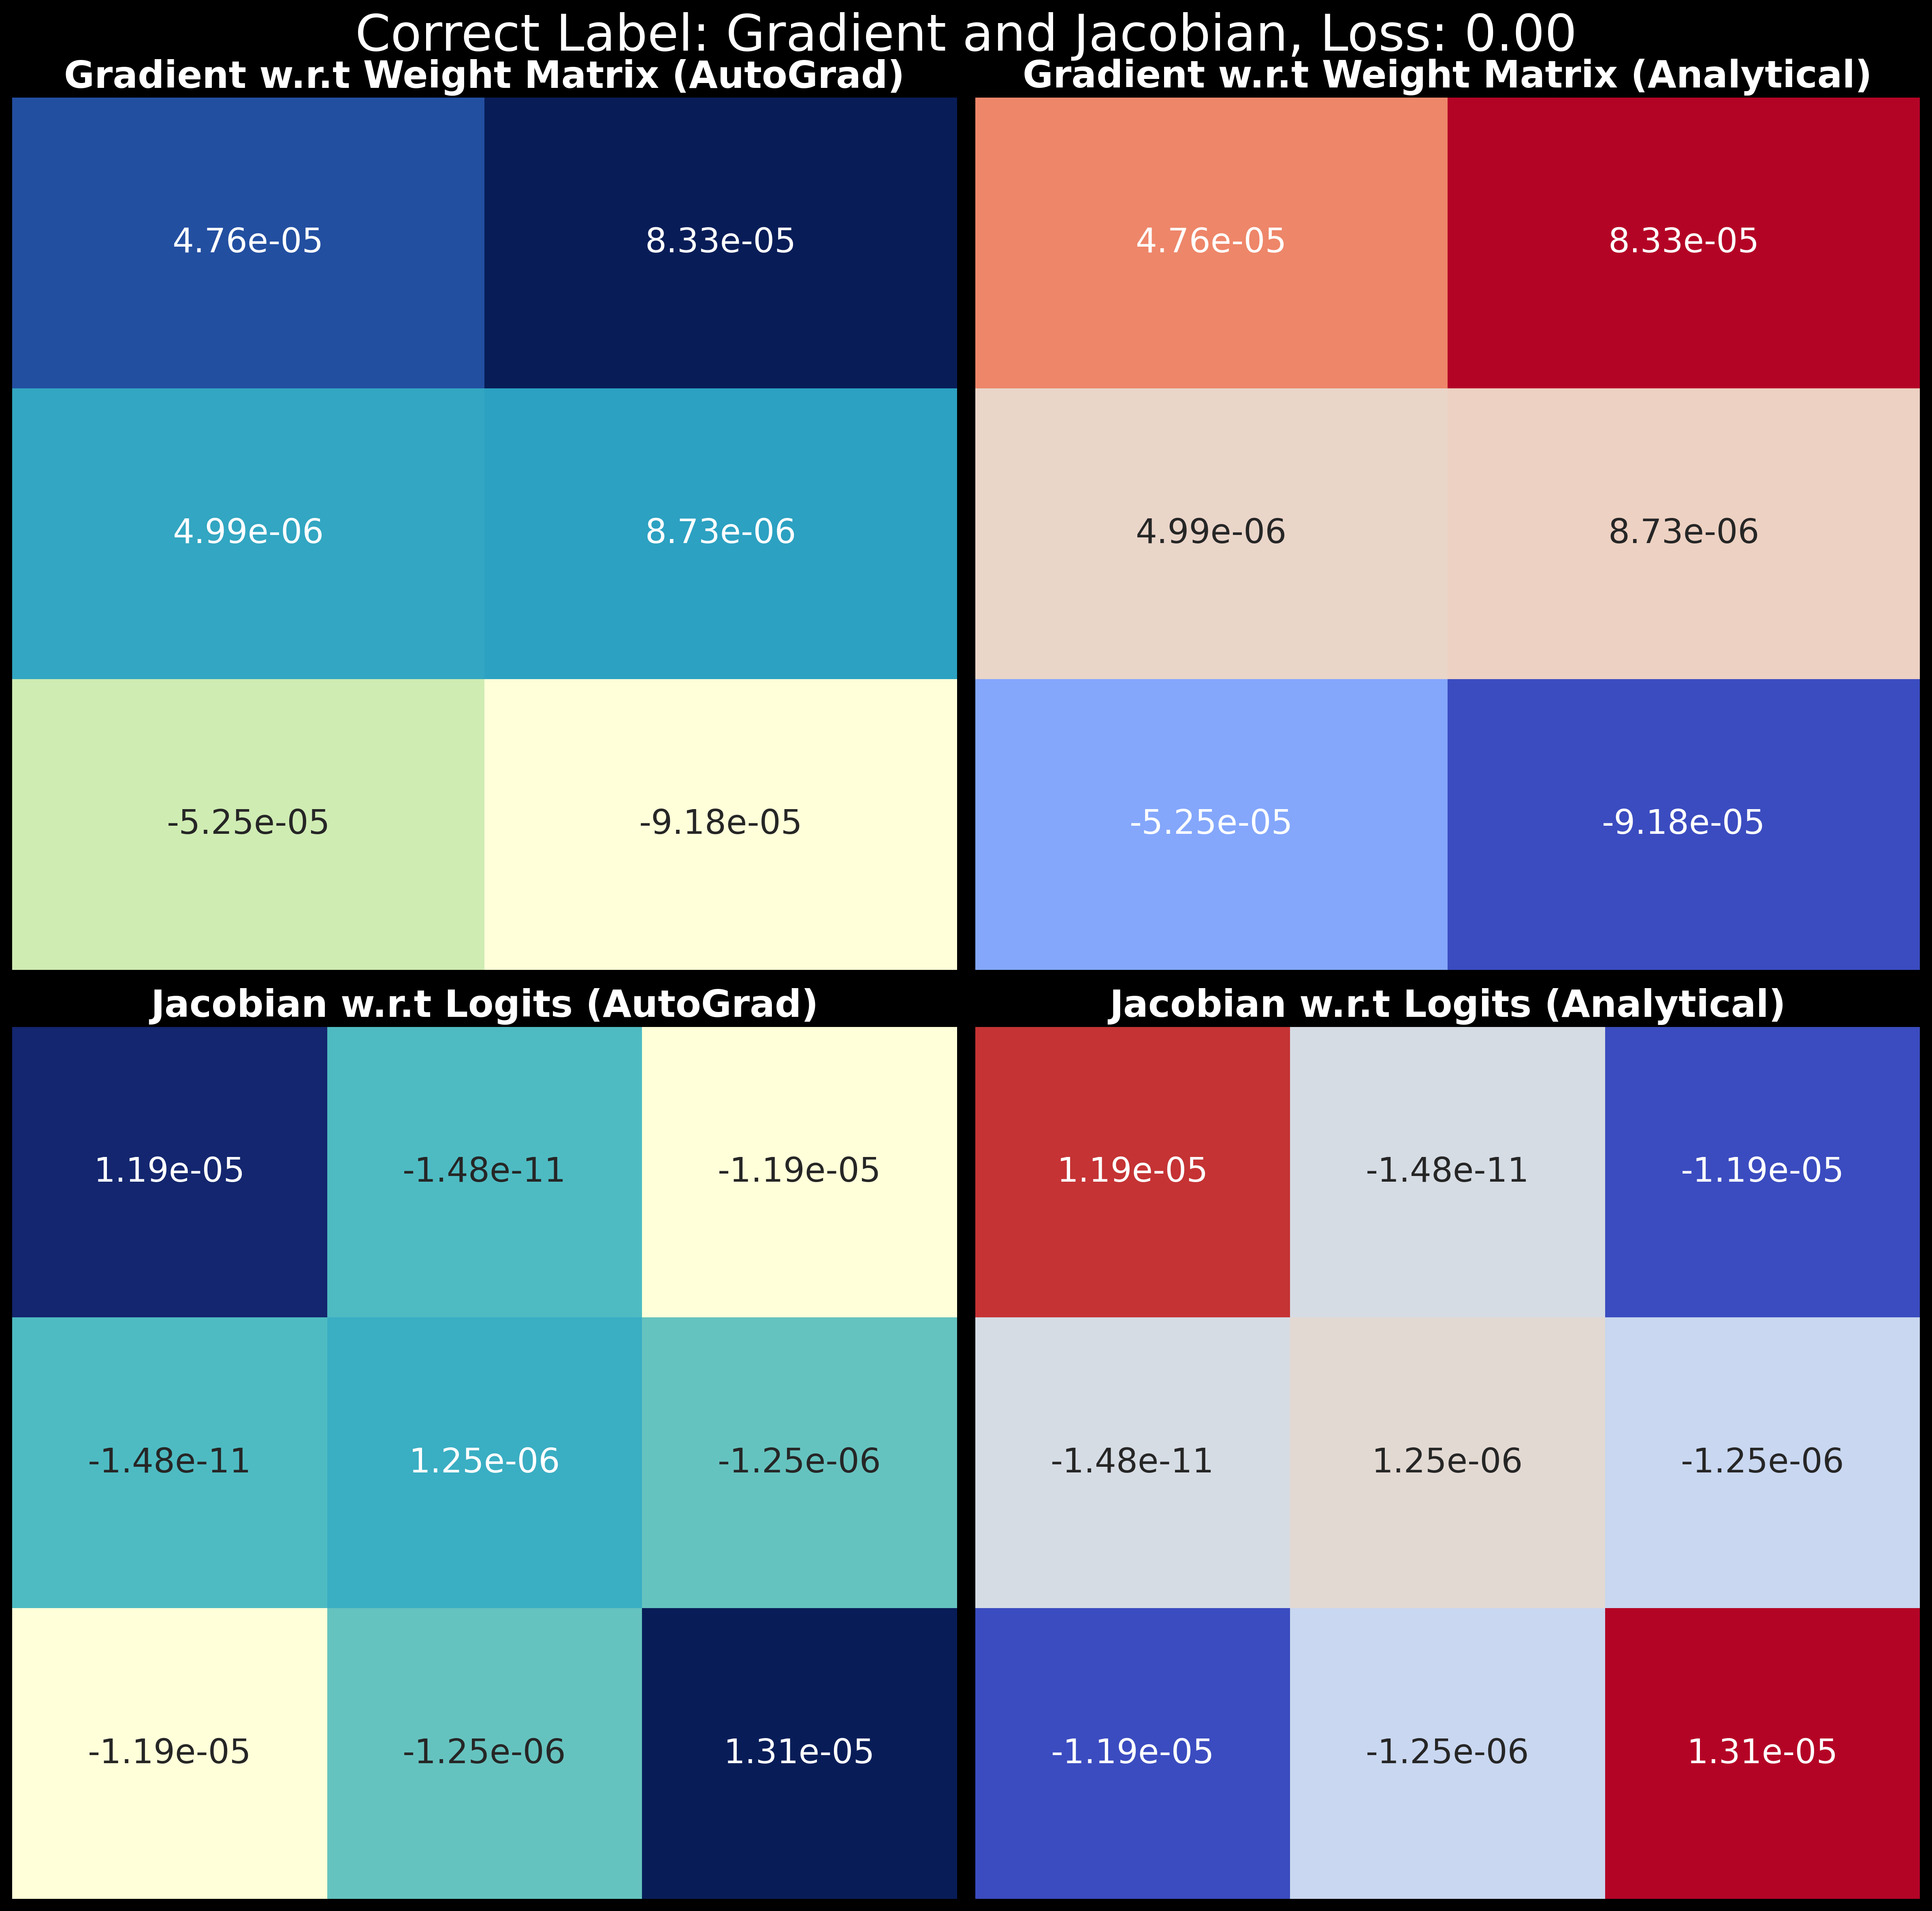

In [7]:
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set aesthetic style and random seed
plt.style.use('dark_background')
SEED = 47
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Functions for reusability

def cross_entropy(ps, label, num_classes):
    """Compute cross-entropy loss."""
    log_ps = torch.log(ps).reshape(num_classes, -1)
    y = torch.nn.functional.one_hot(label, num_classes=num_classes).float()
    return - y @ log_ps

def softmax_fn(logits):
    """Compute softmax."""
    return torch.softmax(logits, dim=0)

def compute_gradients(input_tensor, weight_matrix, label, num_classes):
    """Compute gradients and Jacobians for a given input, weights, and label."""
    # Forward pass
    logits = weight_matrix @ input_tensor
    logits.retain_grad()
    ps = softmax_fn(logits)
    ps.retain_grad()

    # Compute loss and gradients using AutoGrad
    loss = cross_entropy(ps, label, num_classes=num_classes)
    loss.backward(retain_graph=True)

    # Manually compute gradient using the analytical formula
    with torch.no_grad():
        ys = torch.nn.functional.one_hot(label, num_classes=num_classes).reshape(num_classes, 1)
        del_L_wrt_del_p = - ys / ps
        del_p_wrt_del_z = ps @ torch.eye(ps.shape[1]) - ps @ ps.T
        del_L_wrt_del_logits = del_p_wrt_del_z @ del_L_wrt_del_p
        del_L_wrt_W_analytical = (ps - ys) @ input_tensor.T  # Analytical gradient formula

    # Jacobians (using AutoGrad and Analytical)
    jacobian_auto_grad = torch.autograd.functional.jacobian(softmax_fn, logits)
    jacobian_analytical = torch.diag(ps.squeeze()) - ps @ ps.T

    # Results
    return {
        "grad_loss_wrt_W_correct": weight_matrix.grad,  # AutoGrad gradient
        "grad_loss_wrt_W_analytical": del_L_wrt_W_analytical,  # Analytical gradient
        "jacobian_auto_grad": jacobian_auto_grad,
        "jacobian_analytical": jacobian_analytical,
        "loss": loss.item()
    }

def plot_results(results, label, title_mode="Correct"):
    """
    Visualize gradients and Jacobians.
    :param results: Computed gradients and Jacobians.
    :param label: The label to display.
    :param title_mode: 'Correct' or 'Incorrect' to toggle the title.
    """
    title_prefix = "Correct" if title_mode == "Correct" else "Incorrect"
    fig, axes = plt.subplots(2, 2, figsize=(16, 16), dpi=300)

    # Heatmap of gradient w.r.t W (AutoGrad) in scientific notation
    sns.heatmap(
        results["grad_loss_wrt_W_correct"].detach().numpy(),
        annot=True, fmt='.2e', cmap="YlGnBu", cbar=False, ax=axes[0, 0], annot_kws={"size": 20}
    )
    axes[0, 0].set_title('Gradient w.r.t Weight Matrix (AutoGrad)', fontsize=22, weight='bold')
    axes[0, 0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    # Heatmap of gradient w.r.t W (Analytical formula) in scientific notation
    sns.heatmap(
        results["grad_loss_wrt_W_analytical"].detach().numpy(),
        annot=True, fmt='.2e', cmap="coolwarm", cbar=False, ax=axes[0, 1], annot_kws={"size": 20}
    )
    axes[0, 1].set_title('Gradient w.r.t Weight Matrix (Analytical)', fontsize=22, weight='bold')
    axes[0, 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    # Heatmap of Jacobian (AutoGrad) in scientific notation
    sns.heatmap(
        results["jacobian_auto_grad"].detach().numpy().reshape(3, 3),
        annot=True, fmt='.2e', cmap="YlGnBu", cbar=False, ax=axes[1, 0], annot_kws={"size": 20}
    )
    axes[1, 0].set_title('Jacobian w.r.t Logits (AutoGrad)', fontsize=22, weight='bold')
    axes[1, 0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    # Heatmap of Jacobian (Analytical) in scientific notation
    sns.heatmap(
        results["jacobian_analytical"].detach().numpy().reshape(3, 3),
        annot=True, fmt='.2e', cmap="coolwarm", cbar=False, ax=axes[1, 1], annot_kws={"size": 20}
    )
    axes[1, 1].set_title('Jacobian w.r.t Logits (Analytical)', fontsize=22, weight='bold')
    axes[1, 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    # Adjust layout for heatmaps
    fig.suptitle(f'{title_prefix} Label: Gradient and Jacobian, Loss: {results['loss']:.2f}', fontsize=30)
    plt.tight_layout()    
    fig.savefig(f'{title_prefix}.png', dpi=300)
    plt.show()

# Example usage
input_tensor = torch.tensor([[4., 7.]], requires_grad=False).reshape(2, 1)
weight_matrix = torch.randn(3, 2, requires_grad=True)
correct_label = torch.tensor([2])
incorrect_label = torch.tensor([1])
num_classes = 3

# Compute gradients
results = compute_gradients(input_tensor, weight_matrix, correct_label, num_classes)
# Plot results with title mode
plot_results(results, correct_label, title_mode="Correct")  # Change to "Incorrect" for incorrect label

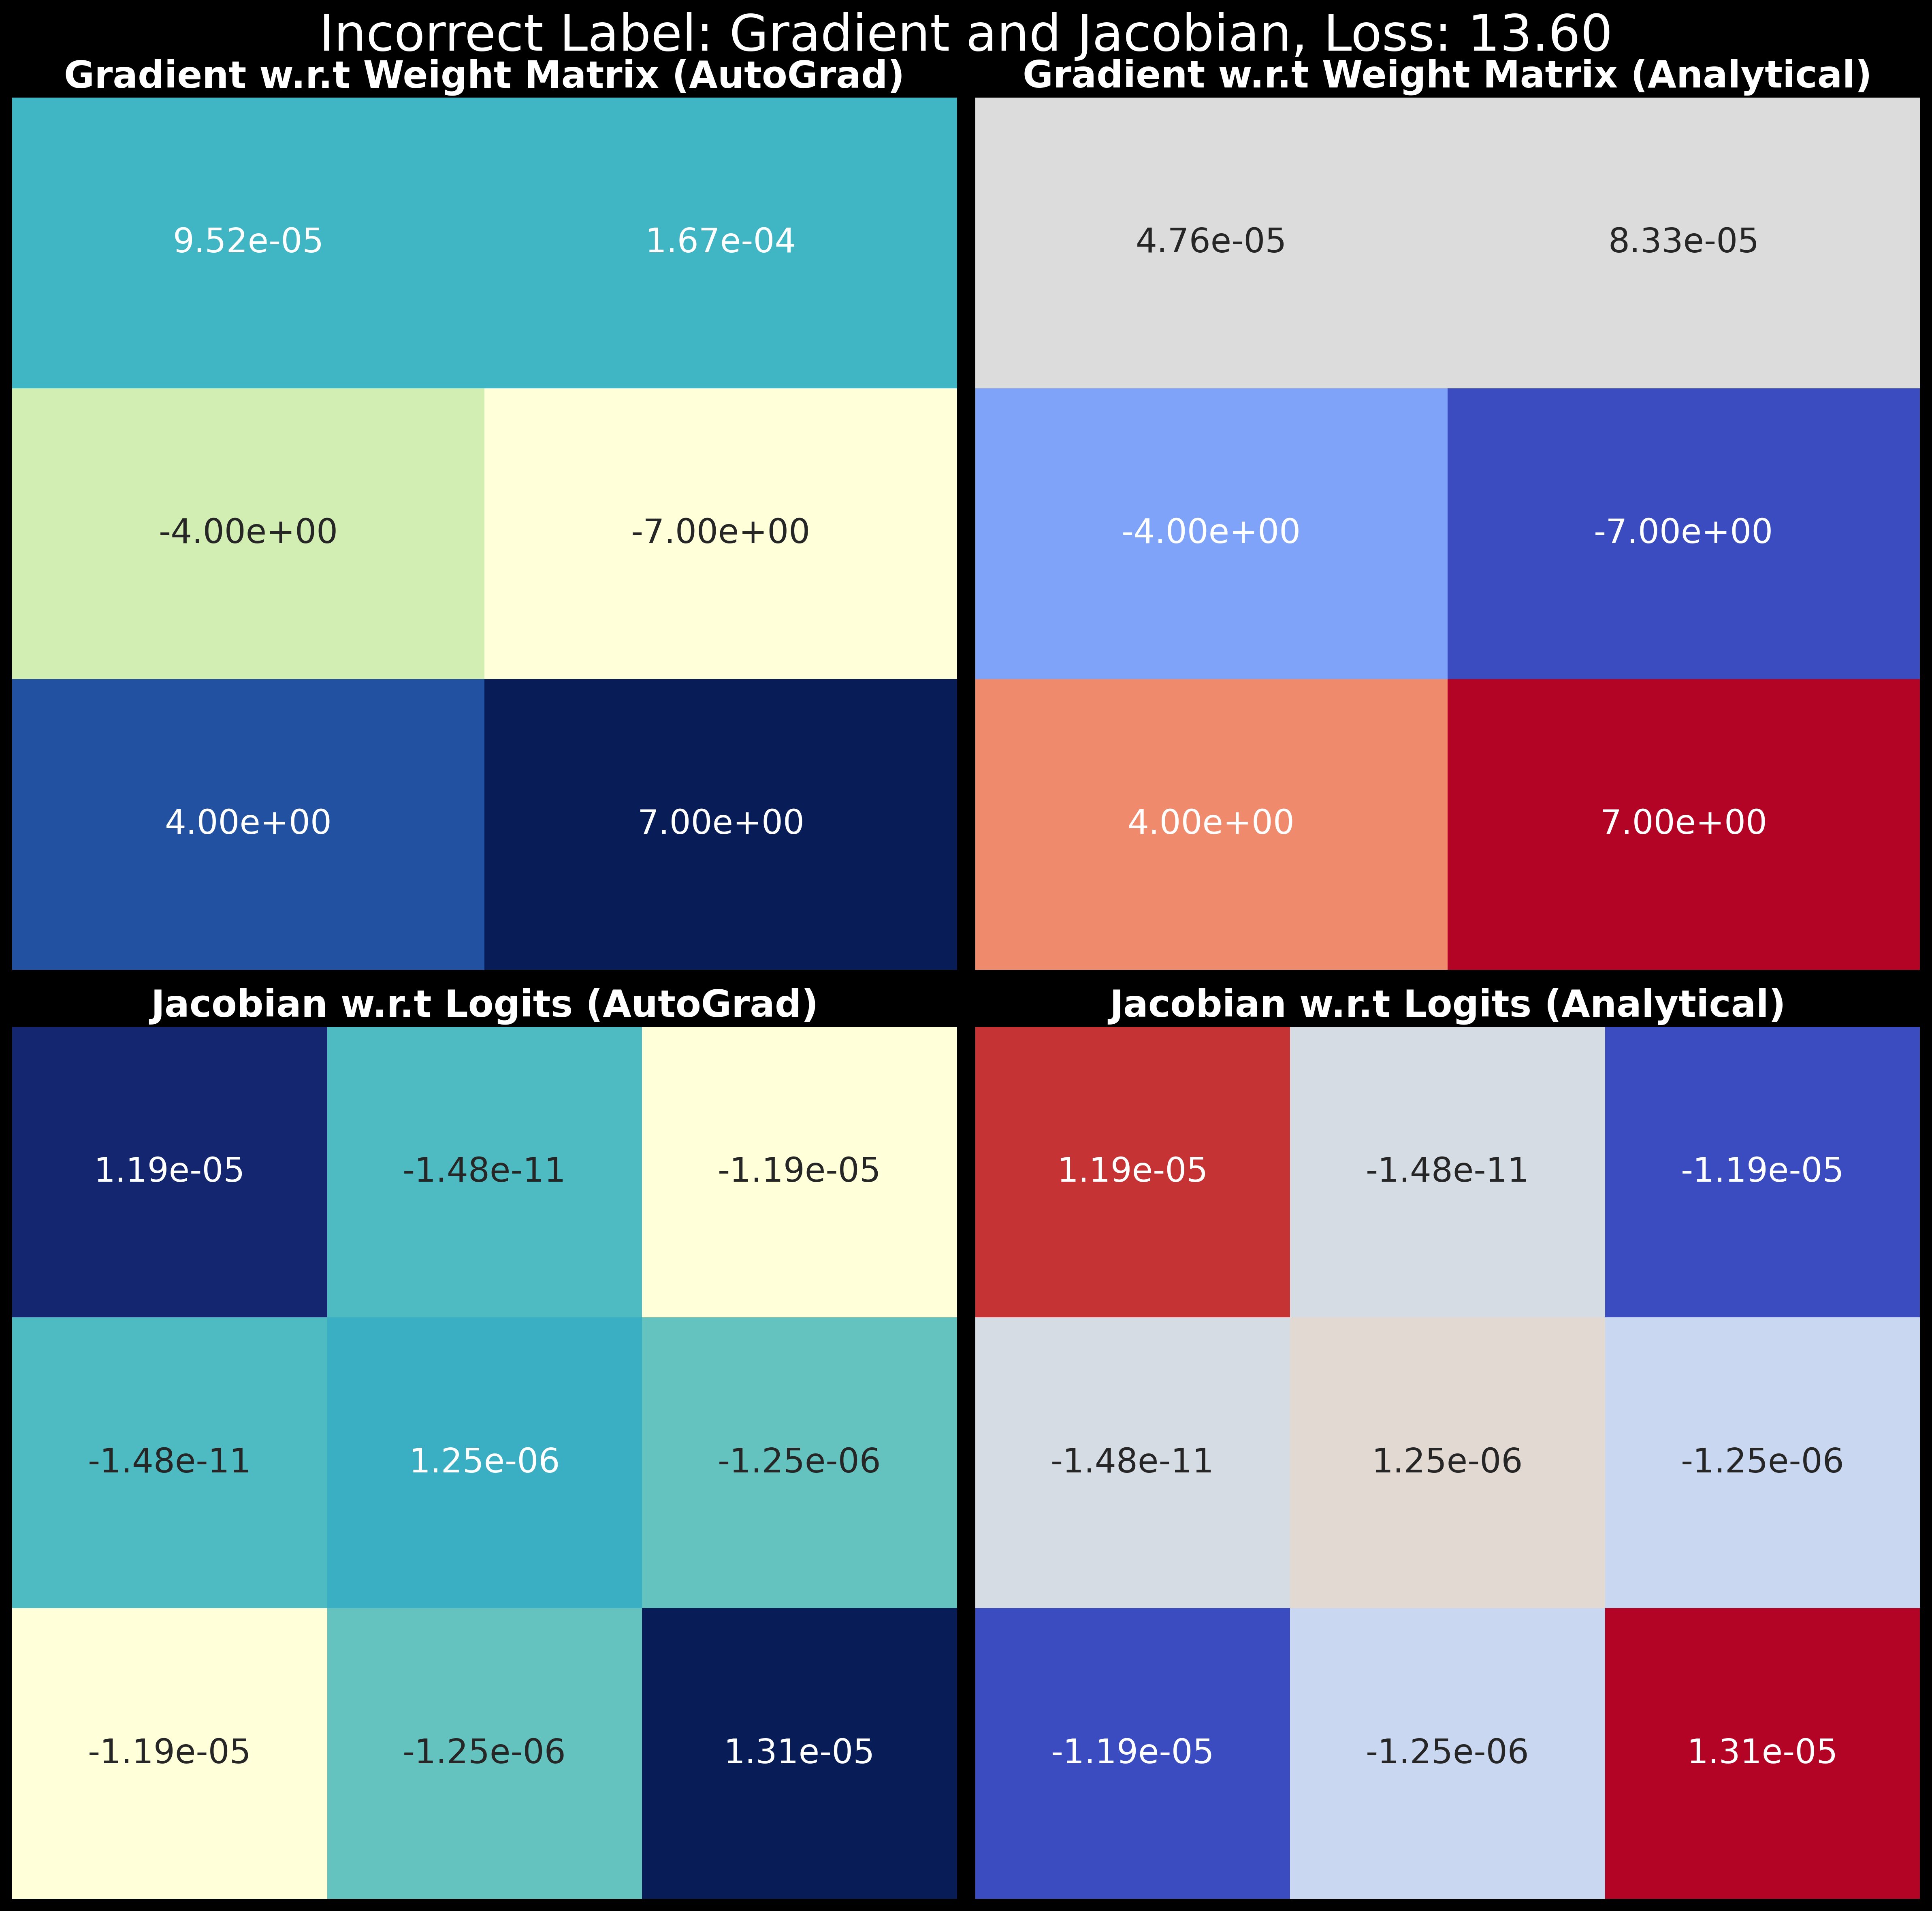

In [8]:
results = compute_gradients(input_tensor, weight_matrix, incorrect_label, num_classes)
plot_results(results, correct_label, title_mode="Incorrect") 

### Jacobian in Gradient Calculation with Math Properties

- **Jacobian in Gradients**:
  - For scalar $L(\mathbf{x})$, the gradient $\nabla_\mathbf{x} L$ is a row vector (special case of Jacobian).
  - For vector $\mathbf{f}(\mathbf{x})$, the Jacobian is a matrix $J_{\mathbf{f}} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}}$, mapping input gradients to output changes.

- **Chain Rule**:
  - Gradients propagate via the chain rule:  
    $$
    \frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{f}} \cdot J_{\mathbf{f}}.
    $$
  - For multi-layer models: Apply chain rule across layers using Jacobian matrices.

- **Neural Networks**:
  - For loss function $L$ and output $\mathbf{y}$, gradient w.r.t. parameters $\mathbf{\theta}$:  
    $$
    \frac{\partial L}{\partial \mathbf{\theta}} = \frac{\partial L}{\partial \mathbf{y}} \cdot J_{\mathbf{y}, \mathbf{\theta}}.
    $$

- **Math Properties**:
  - **Linear Approximation**: The Jacobian approximates small changes in outputs due to changes in inputs (first-order approximation).
  - **Invertibility**: If $\det(J_{\mathbf{f}}) = 0$, the function is locally non-invertible.
  - **Composition**: For composed functions $\mathbf{f}(x) = g(h(x))$, Jacobian is:  
    $$
    J_{\mathbf{f}} = J_g \cdot J_h.
    $$ 
  - **Shape**: If $\mathbf{f}: \mathbb{R}^n \to \mathbb{R}^m$, the Jacobian has dimensions $m \times n$.

- **Automatic Differentiation**:
  - ML frameworks use automatic differentiation to compute Jacobians and gradients efficiently, leveraging reverse-mode differentiation (backpropagation).
